# Assignment #1: linear regression

Leiver Andres Campeón  -  Juan Sebastián Vega Patiño


In this assigment we'll practice linear regression to fit three different datasets.
The goals of this assignment are as follows:

* Implement a linear regression model that uses maximum likelihood. 
* Add regularization factor to the linear regression model implemented.
* Implement a Bayesian linear regression model.

## Mount drive folder

This allows to access files stored in google drive folders.

In [130]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import libraries

For this assigment we're going to use only the following three libraries:

  * numpy for matrix operations.
  * scipy for loading .mat files.
  * matplolib for visualizing results.

In [0]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import preprocessing
%matplotlib inline

# Simple regression example

In the first part we'll work with a very simple dataset with $200$ examples. This data represents a signal for which it has been reported a feature vector $x$, the real labels $y$ and labels with noise $t$.


In [132]:
mat = sio.loadmat('/content/gdrive/My Drive/master ML course/resources/ejemplo_regresion.mat')
x, y, t = mat["x"], mat['y'], mat['t']
num_examples = x.shape[0]
x_mean = np.mean(x)
x_std = np.std(x)

scaled_x = (x - x_mean) / x_std

print(f"Real features shape: {x.shape}")
print(f"Labels shape: {y.shape}")
print(f"Noisy features shape: {t.shape}")


Real features shape: (200, 1)
Labels shape: (200, 1)
Noisy features shape: (200, 1)


## Dataset visualization

In the next cell we can see a figure representing the real and noisy observations. 

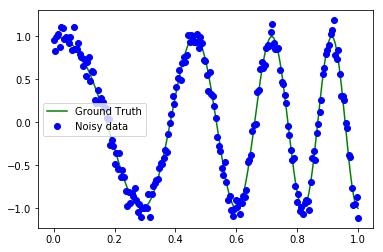

In [133]:
plt.plot(x, y, '-g')
plt.plot(x, t, 'ob')
plt.legend(('Ground Truth', 'Noisy data'))

## Linear regression by maximazing likelihood

In this first part we'll find parameters to fit the dataset by using the normal equation which is the solution to the least squer error function for regression problems. It looks like this:

$$
W = (\Phi^{T}\Phi)^{-1}\Phi t
$$

Where $\Phi$ is a design matrix build from a series of non linear functions of  features $x$, and $t$ are our target labels.

### Useful function for first part

Here you can find utils used for generate desing matrices and visualize result with different $M$ base functions

In [0]:
def apply_base_func(xi, M, base_func):
    new_feature_vec = np.zeros(M)
    degrees = np.linspace(0, M - 1, M)
    if base_func == "poly":
        new_feature_vec = np.power(xi, degrees)
    elif base_func == "sigmoid":
        new_feature_vec = np.full(M, xi)
        s = 0.01
        miu = np.linspace(0, 1, M)
        Z = (xi - miu) / s
        new_feature_vec = 1 / (1 + np.exp(-Z))
    elif base_func == "power":
        s = 0.01
        miu = np.linspace(0, 1, M)
        new_feature_vec = np.exp(-np.power(xi - miu, 2) /(2*s*s))
    return new_feature_vec
 
def generate_features(x_vec, new_features, base_func='poly'):
  """
  Generate a design matrix where its values are given by
  a series of base functions of the provided feature vector x
  Multiple base functions are supported
  """
  if not base_func in ['poly', 'sigmoid', 'power']:
    raise ValueError(f"Base function '{base_func}' not supported")
  num_examples = np.size(x_vec)
  phi_X = np.zeros([num_examples, new_features])
  for i in range(num_examples):
      phi_X[i, :] = apply_base_func(x_vec[i], new_features, base_func)
  return phi_X

In [0]:
def max_likelihood(x_vec, labels, starting_m=10, step=20, base_funct="poly", reg_lambda=None, cases=3, debug=True):
    predictions = []
    m_values = []
    errors = []
    M = starting_m
    num_examples = len(x_vec)
    for test_i in range(cases):
      phi_X = generate_features(x_vec, M, base_funct)
      phi_X_T = phi_X.T
      if reg_lambda:
          print(f'Reg lambda: {reg_lambda}')
          reg_term = reg_lambda * np.eye(phi_X.shape[1])
          inv_term = np.linalg.pinv(reg_term + phi_X_T.dot(phi_X))
      else:
          inv_term = np.linalg.pinv(phi_X_T.dot(phi_X))
      W = inv_term.dot(phi_X_T).dot(labels)

      y_est = phi_X.dot(W)
      predictions.append(y_est)
      m_values.append(M)
      diff = labels - y_est
      error = (1/num_examples) * diff.T.dot(diff)
      errors.append(error)
      if debug:
          r2 = r2_score(labels, y_est)
          print(f"With M:{M}  |  MSE: {np.squeeze(error)} | R2: {r2}")
      M += step
    return predictions, m_values, errors
    

In [0]:
def vis(x, gt, pred, titles):
    fig, axes = plt.subplots(
        nrows=1, ncols=3, sharex=True, sharey=True, figsize = (18,4)
    )
    for idx, y_est in enumerate(pred[:3]):
      plt.subplot(1, 3, idx + 1)
      plt.plot(x, gt,'og')
      plt.plot(x, y_est,'--r')
      plt.legend(('Ground Truth','Prediction'))
      plt.title(f'M={titles[idx]}')

### Linear regression: maximazing likelihood with polynomial base function.

First we'll try to fit the observations by using a design matrix build from polynomial functions of $x$ which makes every cell of this matrix be calculated like this:

$$
\phị̣_{j}(x̣) = x^{j}
$$

With M:6  |  MSE: 0.4070840569072039 | R2: 0.22211152168465165
With M:21  |  MSE: 0.022243930937436512 | R2: 0.9574945338804597
With M:36  |  MSE: 0.01003216799273071 | R2: 0.9808297383263817


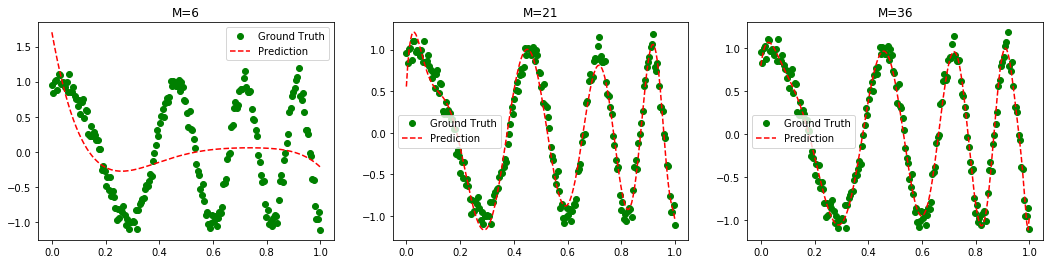

In [137]:
starting_M = 6#@param {type: "slider", min: 0, max: 1000}
base_function = "poly" #@param ["poly", "sigmoid", "power"]

pred_vec, m_values, errors = max_likelihood(x, t, starting_M, 
                                                15, base_function)

vis(x, t, pred_vec, m_values)

### Linear regression: maximazing likelihood with sigmoid base function

Next, we'll try to fit our data by using a design matrix build from sigmoid functions, this time every cell would be calculated like this:

$$
\phị̣_{j}(x) = \sigma(\frac{x - \mu_{j}}{s})
$$

where $\sigma$ is the sigmoid function

$$
\sigma(a) = \frac{1}{1 + e^{-a}}
$$




With M:6  |  MSE: 0.331169552238183 | R2: 0.36717497361077156
With M:21  |  MSE: 0.011795278928540988 | R2: 0.9774606462195119
With M:36  |  MSE: 0.007374693100353264 | R2: 0.9859078519619249


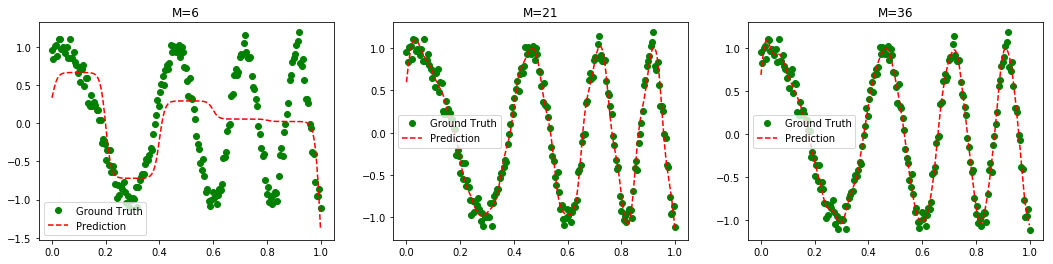

In [139]:
starting_M = 6#@param {type: "slider", min: 0, max: 1000}
base_function = "sigmoid" #@param ["poly", "sigmoid", "power"]

pred_vec, m_values, errors = max_likelihood(x, t, starting_M, 15, base_function)

vis(x, t, pred_vec, m_values)

### Linear regression: maximazing likelihood with exponential base function.

Finally, we'll try with exponential functions, that looks like this:

$$
\phi_{j}(x) = exp\left\{-\frac{(x - \mu_{j})^{2}}{2s^{2}}\right\}
$$


With M:6  |  MSE: 0.42458134568827827 | R2: 0.1886763155801373
With M:21  |  MSE: 0.18024927786693679 | R2: 0.6555653946690572
With M:36  |  MSE: 0.01865296906867932 | R2: 0.9643564284115264


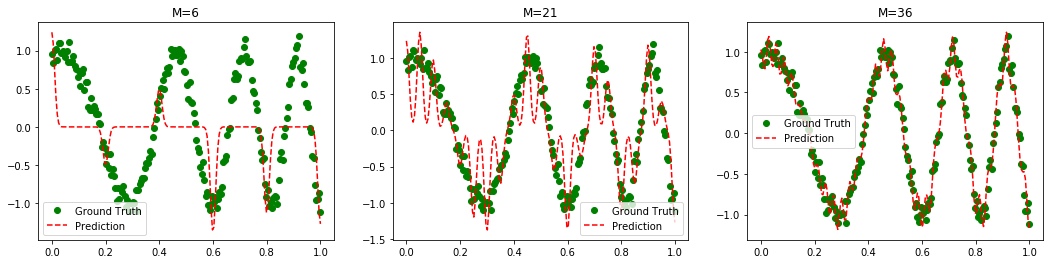

In [140]:
starting_M = 6#@param {type: "slider", min: 0, max: 1000}
base_function = "power" #@param ["poly", "sigmoid", "power"]

pred_vec, m_values, errors = max_likelihood(x, t, starting_M, 15, base_function)

vis(x, t, pred_vec, m_values)


## Discussion

1) First thing we can note is that in order to fit the dataset no matter the base function used, we need to use a high $M$ value greater than 20 for building desing matrix.

2) Other thing that can be observed is that the bigger $M$ value is the better the model fits the dataset. 

3) The functions that transform our data the best into a high dimensional space where is separable are sigmoid like ones.



## Adding regularization

In this section we're going to check how the models trained with different $M$ values are affected by regularization term. Remember than regularization is a technique used to reduce overfitting, in this case we're using $L2$ regularization which will affect the normal equation as follows:

$$
W = (\lambda I + \Phi^{T}\Phi)^{-1} \Phi^{T}t
$$

Where $\lambda$ is the regularization coefficient, $\Phi$ is the design matrix for $x$, and $t$ are the target labels.

For that experimet we'll take best models from previous section and apply regularization technique to them by using  diffent $\lambda$ values. Values used are $0.001, 0.01. 0.1$

Reg lambda: 0.001
With M:36  |  MSE: 0.007374850484069979 | R2: 0.985907551220646
Reg lambda: 0.01
With M:36  |  MSE: 0.007387187512987912 | R2: 0.9858839766480508
Reg lambda: 0.1
With M:36  |  MSE: 0.00777303386144871 | R2: 0.9851466708661736


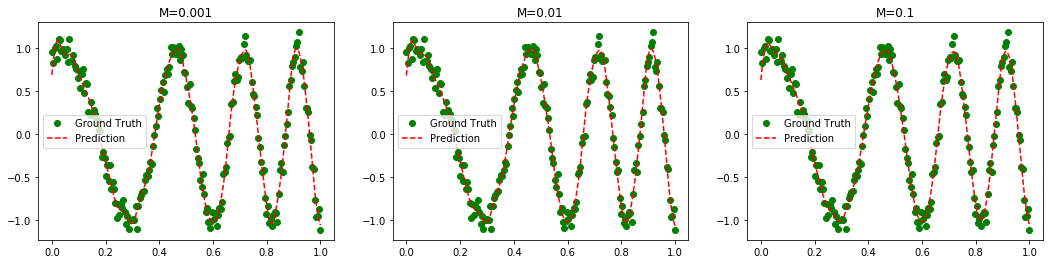

In [141]:
starting_M = 36#@param {type: "slider", min: 0, max: 1000}
base_function = "sigmoid" #@param ["poly", "sigmoid", "power"]
lambda_values = [0.001, 0.01, 0.1]
reg_predictions = []
for lamb in lambda_values:
    pred_vec, _, _ = max_likelihood(x, t, starting_M, 
                                    15, base_function, 
                                    reg_lambda=lamb, 
                                    cases=1)
    reg_predictions.append(pred_vec[0])
    
vis(x, t, reg_predictions, lambda_values)

Reg lambda: 0.001
With M:36  |  MSE: 0.01865300023315054 | R2: 0.9643563688599849
Reg lambda: 0.01
With M:36  |  MSE: 0.018656070802057768 | R2: 0.964350501373567
Reg lambda: 0.1
With M:36  |  MSE: 0.01894902227619364 | R2: 0.963790706479689


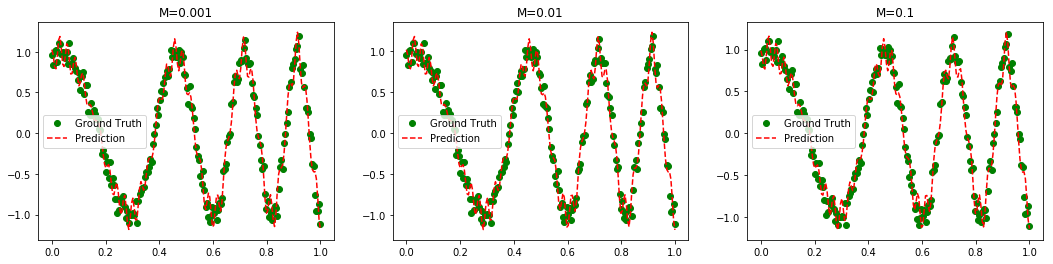

In [142]:
starting_M = 36#@param {type: "slider", min: 0, max: 1000}
base_function = "power" #@param ["poly", "sigmoid", "power"]
lambda_values = [0.001, 0.01, 0.1]
reg_predictions = []
for lamb in lambda_values:
    pred_vec, _, _ = max_likelihood(x, t, starting_M, 
                                    15, base_function, 
                                    reg_lambda=lamb, 
                                    cases=1)
    reg_predictions.append(pred_vec[0])
    
vis(x, t, reg_predictions, lambda_values)

Reg lambda: 0.001
With M:36  |  MSE: 0.3461331955367448 | R2: 0.3385812580916564
Reg lambda: 0.01
With M:36  |  MSE: 0.3679280374333122 | R2: 0.2969339469027804
Reg lambda: 0.1
With M:36  |  MSE: 0.4182382651141328 | R2: 0.2007971766453952


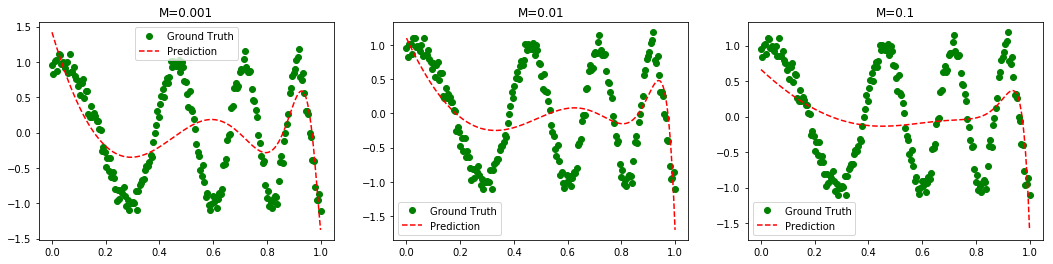

In [143]:
starting_M = 36#@param {type: "slider", min: 0, max: 1000}
base_function = "poly" #@param ["poly", "sigmoid", "power"]
lambda_values = [0.001, 0.01, 0.1]
reg_predictions = []
for lamb in lambda_values:
    pred_vec, _, _ = max_likelihood(x, t, starting_M, 
                                    15, base_function, 
                                    reg_lambda=lamb, 
                                    cases=1)
    reg_predictions.append(pred_vec[0])
    
vis(x, t, reg_predictions, lambda_values)

## Discussion


From previous experiment we can tell that the models trained with exponential and sigmoid base function were almost not affected by the regularization term, however polinomial base function was really affect even for lower $\lambda$ value.


In the case of exponential and sigmoid base function one would have to use another strategy to fix overfitting (e.g use simpler model, train with more data, etc)


## Bayesian linear regression

Third part of this linear regression assignment consist in using a Bayesian model to fit proposed training dataset, this method find paramenters $\alpha$ and $\beta$ iteratively based on the data and trying to avoid overfitting.

Mean MSE for 10 runs = 0.006790662808841666 +- 1.5218157128205882e-12 
Mean R2 for 10 runs = 0.9870238633287312 +- 2.907996207295978e-12


Text(0, 0.5, 'logEv')

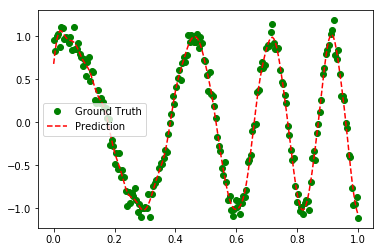

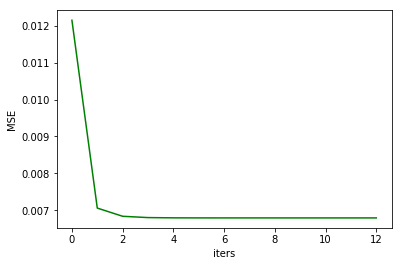

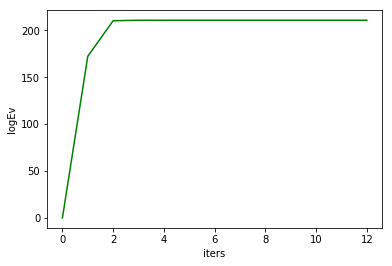

In [145]:
iters = 13 #@param {type: "slider", min: 1, max: 100}
M = 84 #@param {type: "slider", min: 0, max: 100}
N = x.shape[0]

def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

m_phi_X = generate_features(x, M, 'sigmoid')
num_runs = 10
runs_error = []
runs_r2 = []
for run in range(num_runs):
  alpha = np.random.rand()
  beta = np.random.rand()
  m_phi_X_T = m_phi_X.T
  inv_term = alpha * np.eye(M) + beta * (m_phi_X_T.dot(m_phi_X))
  inv_term = np.linalg.inv(inv_term)
  W_mn = beta * inv_term.dot(m_phi_X_T).dot(t)

  y_est = m_phi_X.dot(W_mn)
  error = np.zeros(iters)
  diff = t - y_est
  error[0] = (1/N) * diff.T.dot(diff)

  # Calculamos autovalores de PHIT*PHI
  rho = np.real(np.linalg.eigvals(m_phi_X_T.dot(m_phi_X)))
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))
  logEv = np.zeros(iters)

  N = x.shape[0]
  #W_mn = np.squeeze(mn)
  t  = np.squeeze(t)
  for it in range(1, iters):
    alpha = Gamma / W_mn.T.dot(W_mn)
    norm_t_phi = t - m_phi_X.dot(W_mn)
    invBeta = 1./(N - Gamma) * (norm_t_phi.T.dot(norm_t_phi))
    beta = 1./invBeta
    #Se actualizan los parametros del posterior
    inv_sn = alpha * np.eye(M) + beta * m_phi_X_T.dot(m_phi_X)
    Sn = np.linalg.inv(inv_sn)
    W_mn = beta * Sn.dot(m_phi_X_T).dot(t)
    Lambda = beta * rho
    Gamma = np.sum(Lambda / (alpha + Lambda))

    #Se calcula el error
    y_est = m_phi_X.dot(W_mn)
    diff = t - y_est
    r2 = r2_score(t, y_est)
    error[it] = np.squeeze((1/N) * diff.T.dot(diff))
    logEv[it] = logEvi(inv_sn, alpha, beta, 2 * error[it])
  runs_error.append(error[-1])
  runs_r2.append(r2)
   
errors = np.array(runs_error)
mean_error = np.mean(errors)
error_std = np.std(errors)

r2_vals = np.array(runs_r2)
mean_r2 = np.mean(r2_vals)
r2_std = np.std(r2_vals)
print(f"Mean MSE for {num_runs} runs = {mean_error} +- {error_std} ")
print(f"Mean R2 for {num_runs} runs = {mean_r2} +- {r2_std}")

plt.plot(x, t, 'og')
plt.plot(x, y_est, '--r')
plt.legend(('Ground Truth','Prediction'))

plt.figure(2)
plt.plot(error, '-g')
plt.xlabel('iters')
plt.ylabel('MSE')

plt.figure(3)
plt.plot(logEv, '-g')
plt.xlabel('iters')
plt.ylabel('logEv')

## Discussion

As can be observed in the error chart first model is good enough, however after some few iterations it gets way better.

This experiment was ran 10 time in order to get a mean error metric, from those results we can say that the method is pretty stable since standard deviation was around $1e^{-11}$ for a error value of $\approx0.0068$

# Energy consumption dataset

Let's apply the concepts learnt with the previous three linear regression techniques to a new dataset.

This dataset contains $25$ observations of average power consumption during a several days.

In [0]:
mat = sio.loadmat('/content/gdrive/My Drive/master ML course/resources/consumoDB.mat')
x_consu, t_consu = mat["x"], mat['t']

num_examples = x_consu.shape[0]
x_consu_mean = np.mean(x_consu)
x_consu_std = np.std(x_consu)
x_consu_scaled = (x_consu - x_consu_mean) / x_consu_std

## Data visualization



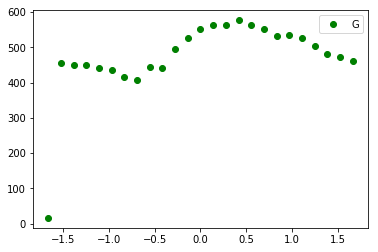

In [147]:
plt.plot(x_consu_scaled, t_consu, 'og')
plt.legend(('Ground Truth'))

## Linear regression by maximazing likelihood (sigmoid as base function)

We'll start with normal equation and a design matrix build with sigmoid function of $x$

With M:5  |  MSE: 4183.229347789229 | R2: 0.6326674267714704
With M:25  |  MSE: 28.57650767876809 | R2: 0.997490674972178
With M:45  |  MSE: 172615.43589170568 | R2: -14.157493642698382


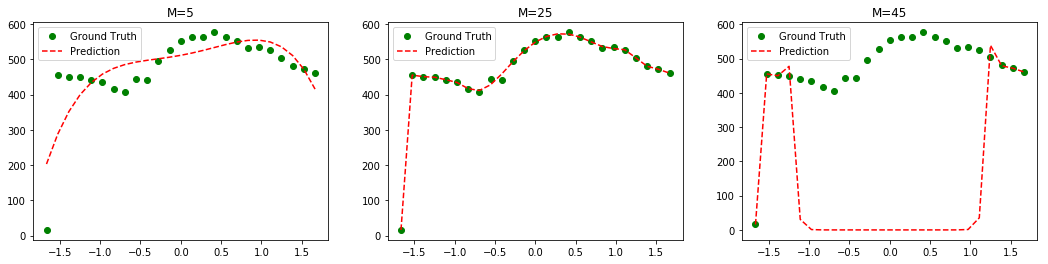

In [148]:
starting_M = 5#@param {type: "slider", min: 0, max: 50}
base_function = "poly" #@param ["poly", "sigmoid", "power"]

consu_pred_vec, m_values, errors = max_likelihood(x_consu_scaled, t_consu, 
                                                  starting_M, 20, 
                                                  base_function)

vis(x_consu_scaled, t_consu, consu_pred_vec, m_values)

## Discussion

We noted that in all cases the model had difficulties trying to fit the the outlier when $M$ value was below $10$.

It's pretty interesting that with a very high $M$ value the models struggles to fit the data points. At the end we can say that  better performaces is obtained with $M$ values around $25$. 

In this schema the estimation fits very well all the training obvervations however there is an outlier which makes that the MSE increases a lot.


## Applying regularization

Now, let's pick the best linear regression model which was the one using $M = 25$ and test how is this affected by regularization schema that we proposed for the first dataset (e.i $\lambda \in \{0.1, 0.01, 0.001\}$).

Reg lambda: 0.001
With M:25  |  MSE: 29.018685847567355 | R2: 0.9974518469684837
Reg lambda: 0.01
With M:25  |  MSE: 38.74332235068901 | R2: 0.9965979191884322
Reg lambda: 0.1
With M:25  |  MSE: 131.7381493446353 | R2: 0.9884319721994914


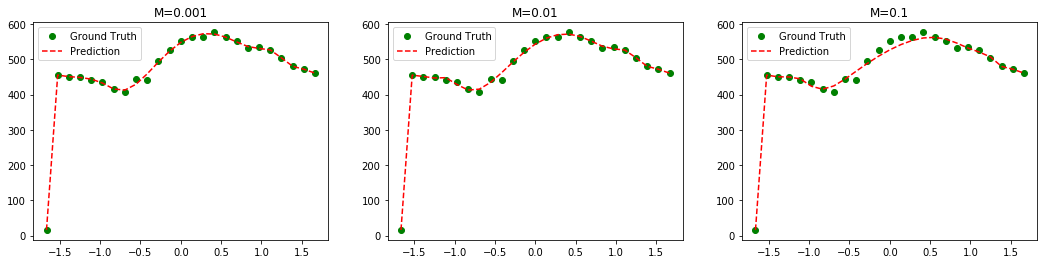

In [149]:
starting_M = 25#@param {type: "slider", min: 0, max: 50}
base_function = "poly" #@param ["poly", "sigmoid", "power"]
lambda_values = [0.001, 0.01, 0.1]
reg_predictions = []
for lamb in lambda_values:
    pred_vec, _, _ = max_likelihood(x_consu_scaled, t_consu, 
                                    starting_M, 10,
                                    base_function, 
                                    reg_lambda=lamb, 
                                    cases=1)
    reg_predictions.append(pred_vec[0])

    
vis(x_consu_scaled, t_consu, reg_predictions, lambda_values)

## Discussion

From charts we could say that the model is not affected for the regularization term, then if we check error metric we can note that using $\lambda = 0.1$ **MSE** goes from $28,57$ to $131.73$, which is for sure increment of the error, but it's still not a big change, taking the scale into account.

## Bayesian linear regression

Finally for this dataset we'll check what happens when we try to fit the data with a Bayesian strategy.

Mean MSE for 10 runs = 30.900726624080608 +- 0.0027020903867913805 
Mean R2 for 10 runs = 0.9972865835263244 +- 2.3727262656546244e-07


Text(0, 0.5, 'logEv')

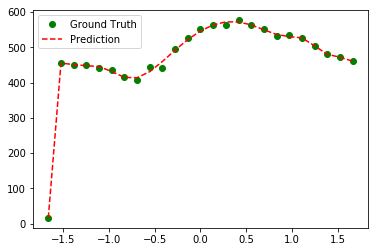

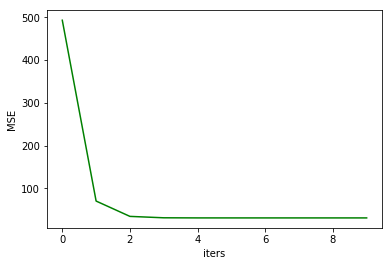

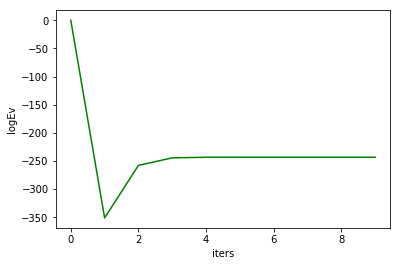

In [151]:
iters = 10 #@param {type: "slider", min: 1, max: 25}
M = 25 #@param {type: "slider", min: 0, max: 50}
N = x_consu_scaled.shape[0]

def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi

m_phi_X = generate_features(x_consu_scaled, M, 'poly')
num_runs = 10
runs_error = []
runs_r2 = []
for run in range(num_runs):
  alpha = np.random.rand() * 0.01
  beta = np.random.rand() * 0.01
  error = np.zeros(iters)
  logEv = np.zeros(iters)

  m_phi_X_T = m_phi_X.T
  inv_sn = alpha * np.eye(M) + beta * (m_phi_X_T.dot(m_phi_X))
  sn = np.linalg.inv(inv_sn)
  W_mn = beta * sn.dot(m_phi_X_T).dot(t_consu)
  y_est = m_phi_X.dot(W_mn)
  diff = t_consu - y_est
  error[0] = np.squeeze((1/N) * diff.T.dot(diff))
  # Calculamos autovalores de PHIT*PHI
  rho = np.real(np.linalg.eigvals(m_phi_X_T.dot(m_phi_X)))
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  t_consu  = np.squeeze(t_consu)
  for it in range(1, iters):
    alpha = Gamma / W_mn.T.dot(W_mn)
    norm_t_phi = t_consu - m_phi_X.dot(W_mn)
    invBeta = 1./(N - Gamma) * (norm_t_phi.T.dot(norm_t_phi))
    beta = 1./invBeta
    #Se actualizan los parametros del posterior
    inv_sn = alpha * np.eye(M) + beta * m_phi_X_T.dot(m_phi_X)
    Sn = np.linalg.inv(inv_sn)
    W_mn = beta * Sn.dot(m_phi_X_T).dot(t_consu)
    Lambda = beta * rho
    Gamma = np.sum(Lambda / (alpha + Lambda))

    #Se calcula el error
    y_est = m_phi_X.dot(W_mn)
    diff = t_consu - y_est
    r2 = r2_score(t_consu, y_est)
    error[it] = np.squeeze((1/N) * diff.T.dot(diff))
    logEv[it] = logEvi(inv_sn, alpha, beta, 2 * error[it])
  runs_error.append(error[-1])
  runs_r2.append(r2)
errors = np.array(runs_error)
mean_error = np.mean(errors)
error_std = np.std(errors)

r2_vals = np.array(runs_r2)
mean_r2 = np.mean(r2_vals)
r2_std = np.std(r2_vals)
print(f"Mean MSE for {num_runs} runs = {mean_error} +- {error_std} ")
print(f"Mean R2 for {num_runs} runs = {mean_r2} +- {r2_std}")


plt.plot(x_consu_scaled, t_consu, 'og')
plt.plot(x_consu_scaled, y_est, '--r')
plt.legend(('Ground Truth','Prediction'))

plt.figure(2)
plt.plot(error, '-g')
plt.xlabel('iters')
plt.ylabel('MSE')

plt.figure(3)
plt.plot(logEv, '-g')
plt.xlabel('iters')
plt.ylabel('logEv')



## Discussion

After running this schema 10 times we got a average MSE metric of $30.9\pm0.002$, which is a pretty good value, but not as good as the one found using maximum likelihood.

In the error chart we can confirm again that first model attemp is a pretty poor fit to the data, but it converge to a good fit pretty fast, just a couple of iterations.

# HR signal dataset

In this last section we're going to do same experiments that with energy consumption dataset, but with a bigger and more complicated dataset. This dataset contains 6528 examples that describes the variability of the heart rate in emotional processes.

In [0]:
mat = sio.loadmat('/content/gdrive/My Drive/master ML course/resources/HRsignal.mat')
hr_x, hr_labels = mat["x"].T, mat['HR']
hr_mean = np.mean(hr_x)
hr_std = np.std(hr_x)

hr_labels = (hr_labels - np.mean(hr_labels)) / np.std(hr_labels)

## Data visualization

As we can see in the following figure this is a pretty challenging dataset.

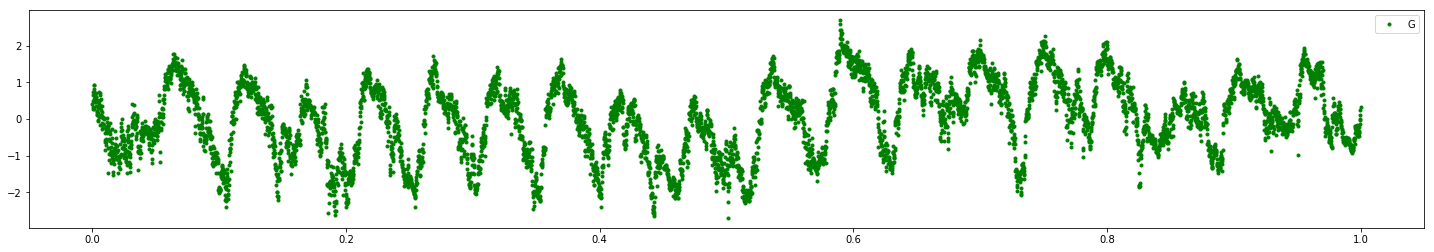

In [159]:
plt.figure(figsize=(25, 4))
plt.plot(hr_x, hr_labels, '.g')
plt.legend(('Ground Truth'))

## Max likelihood

Same as before we're going to start with normal equation and a design matrix build with sigmoid functions of $x$

With M:30  |  MSE: 0.6881407069526685 | R2: 0.3118592930473314
MSE: 0.12832712141728186


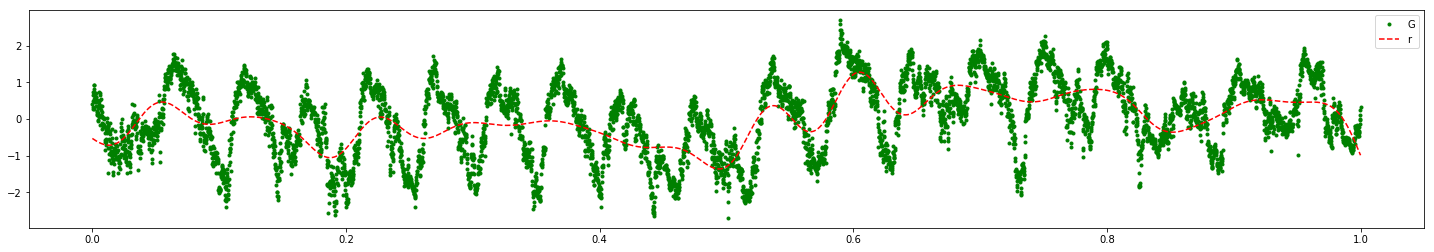

In [160]:
starting_M = 30#@param {type: "slider", min: 0, max: 1000}
base_function = "sigmoid" #@param ["poly", "sigmoid", "power"]

pred_vec, m_values, errors = max_likelihood(hr_x, 
                                            hr_labels, starting_M, 300, 
                                            base_function, cases=1)
print(f"MSE: {error[0]}")
plt.figure(figsize=(25, 4))
plt.plot(hr_x, hr_labels, '.g')
plt.plot(hr_x, pred_vec[0], '--r')
plt.legend(('Ground Truth'))

With M:500  |  MSE: 0.08506394953383144 | R2: 0.9149360504661685


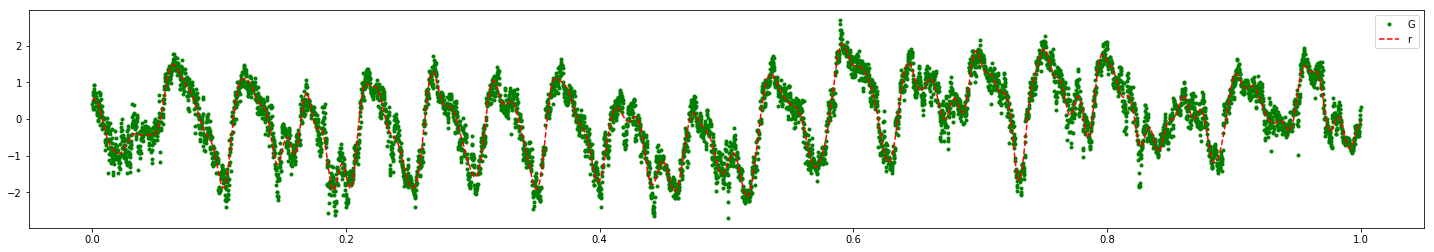

In [161]:
starting_M = 500#@param {type: "slider", min: 0, max: 1000}
base_function = "sigmoid" #@param ["poly", "sigmoid", "power"]

pred_vec, m_values, errors = max_likelihood(hr_x, 
                                            hr_labels, starting_M, 300, 
                                            base_function, cases=1)

plt.figure(figsize=(25, 4))
plt.plot(hr_x, hr_labels, '.g')
plt.plot(hr_x, pred_vec[0], '--r')
plt.legend(('Ground Truth'))

## Discussion

In this section we try first an $M$ value of $30$ which in the two previous experiments gave us good results, however this time we found that this number of non linear functions were not enough for the complexity of this dataset. 
Next we increased notably $M$, ending up with a value of $M=800$ which sort of fits the dataset in a acceptable way. Last model got an error value of $MSE = 0.08$.

## Bayesian linear regression

Second approach we're going to test with this dataset is the Bayesian estimation.

Mean MSE for 10 runs = 0.09688515749728178 +- 2.0093098766068416e-07 
Mean R2 for 10 runs = 0.9031148425027181 +- 2.0093098766914565e-07


Text(0, 0.5, 'logEv')

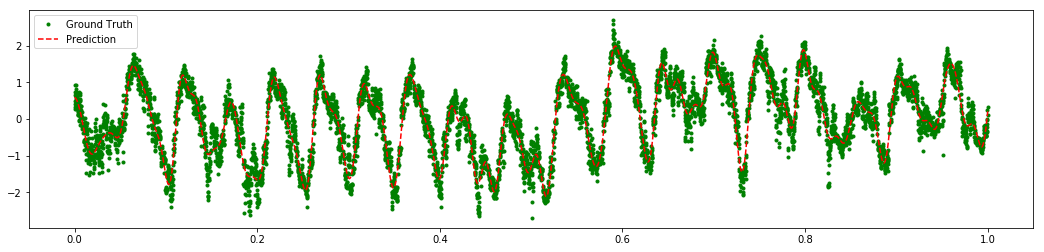

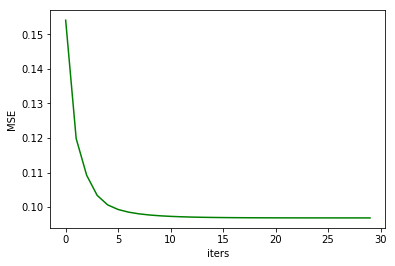

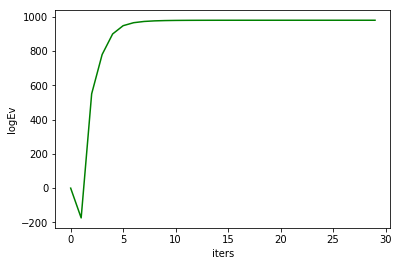

In [163]:
iters = 30 #@param {type: "slider", min: 1, max: 50}
M = 200 #@param {type:"slider", min:0, max:500, step:1}
N = hr_x.shape[0]

def half_ln(N, X):
  return 0.5 * N * np.log(X + 1e-20)

def logEvi(A, alpha, beta, error_mn):
  log_evi = half_ln(M, alpha) + half_ln(N, beta) - error_mn - half_ln(1, np.linalg.det(A)) - half_ln(N, 2*np.pi)
  return log_evi


num_runs = 10
runs_error = []
runs_r2 = []
m_phi_X = generate_features(hr_x, M, 'power')

for run in range(num_runs):
  alpha = np.random.rand() * 0.01
  beta = np.random.rand() * 0.01
  error = np.zeros(iters)
  logEv = np.zeros(iters)

  m_phi_X_T = m_phi_X.T
  inv_sn = alpha * np.eye(M) + beta * (m_phi_X_T.dot(m_phi_X))
  sn = np.linalg.inv(inv_sn)
  W_mn = beta * sn.dot(m_phi_X_T).dot(hr_labels)
  y_est = m_phi_X.dot(W_mn)
  diff = hr_labels - y_est

  error[0] = np.squeeze((1/N) * diff.T.dot(diff))

  # Calculamos autovalores de PHIT*PHI
  rho = np.linalg.eigvals(m_phi_X_T.dot(m_phi_X))
  Lambda = beta * rho
  Gamma = np.sum(Lambda / (alpha + Lambda))

  hr_labels  = np.squeeze(hr_labels)
  for it in range(1, iters):
    alpha = Gamma / W_mn.T.dot(W_mn)
    norm_t_phi = hr_labels - m_phi_X.dot(W_mn)
    invBeta = 1./(N - Gamma) * (norm_t_phi.T.dot(norm_t_phi))
    beta = 1./invBeta
    #Se actualizan los parametros del posterior
    inv_sn = alpha * np.eye(M) + beta * m_phi_X_T.dot(m_phi_X)
    Sn = np.linalg.inv(inv_sn)
    W_mn = beta * Sn.dot(m_phi_X_T).dot(hr_labels)
    Lambda = beta * rho
    Gamma = np.sum(Lambda / (alpha + Lambda))

    #Se calcula el error
    y_est = m_phi_X.dot(W_mn)
    diff = hr_labels - y_est
    error[it] = np.squeeze((1/N) * diff.T.dot(diff))
    logEv[it] = logEvi(inv_sn, alpha, beta, 2 * error[it])
  r2 = r2_score(hr_labels, y_est)
  runs_error.append(error[-1])
  runs_r2.append(r2)
errors = np.array(runs_error)
mean_error = np.mean(errors)
error_std = np.std(errors)

r2_vals = np.array(runs_r2)
mean_r2 = np.mean(r2_vals)
r2_std = np.std(r2_vals)
print(f"Mean MSE for {num_runs} runs = {mean_error} +- {error_std} ")
print(f"Mean R2 for {num_runs} runs = {mean_r2} +- {r2_std}")
    
plt.figure(figsize=(18, 4))
plt.plot(hr_x, hr_labels, '.g')
plt.plot(hr_x, y_est, '--r')
plt.legend(('Ground Truth', 'Prediction'))

plt.figure(2)
plt.plot(error, '-g')
plt.xlabel('iters')
plt.ylabel('MSE')

plt.figure(3)
plt.plot(logEv, '-g')
plt.xlabel('iters')
plt.ylabel('logEv')

## Discussion

After running this schema $10$ times we got a average $MSE$ metric of $0.09\pm1e^{-7}$, which we consider a very good estimation, besides that we found it stable since estandar deviation was $1e^{-7}$.

From error chart we noted that this time it took a more iterations to converge than in previous datasets, but this was expected because as we said before it's a challenging dataset, however at the end it could get a good estimation.

# Conclusions

  *  We successfully experiment the performance of three different linear regression strategies for three very different dataset, from pretty simple with very little examples to very challenging and conderably large examples.

  *   In this assignment we learnt the importance of hyperparameter tuning in order to get the best possible model depending of the dataset we want to fit.